In [882]:
import pandas as pd
import os

TITANIC_PATH = 'titanic'

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [883]:
train_df = load_titanic_data('train.csv')
test_df = load_titanic_data('test.csv')

data_df = train_df.append(test_df)
data_df

/var/folders/rl/pyfz32cs4rq01p8c57cwqj6m0000gn/T/ipykernel_32566/3425973428.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = train_df.append(test_df)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [884]:
def preprocess_data(data_df):
    # Plots from first attempt processing file show that being female or child has
    # huge impact on survival

    # New feature will focus on it
    # We can get rid of those complicated titles and introduce man, woman, boy
    # Because even high born males has significantly lower chance of survival
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
    data_df['Title(Copy)'] = data_df['Title']      

    data_df.loc[data_df['Sex'] == 'female', 'Title'] = 'woman'
    data_df.loc[data_df['Title'] == 'Master', 'Title'] = 'boy'
    data_df.loc[(data_df['Title'] != 'woman') & (data_df['Title'] != 'boy'), 'Title'] = 'man'

    data_df['FamilyName'] = data_df['Name'].str.extract('(\w+),', expand=False)

    # A few factors contribute to ticket it might be easier to read them from other columns
    # When people are on the titanic together sometimes their tickets differs on last position
    data_df['ExtendedTicket'] = data_df['Pclass'].astype('str') + '-' + data_df['Embarked'].astype('str') + \
        '-' + data_df['Fare'].astype('str') + '-' + data_df['Ticket'].str[:-1]


    # Create groups of people 
    data_df['PeopleGroup'] = data_df['FamilyName'] + '-' + data_df['ExtendedTicket']
    data_df.loc[data_df['Title'] == 'man', 'PeopleGroup'] = 'alone'
    
    mapping = data_df.loc[data_df['Title'] != 'man', 'PeopleGroup'].value_counts()
    data_df['GroupSize'] = data_df['PeopleGroup'].map(mapping)
    data_df['GroupSize'].fillna(1, inplace=True)

    data_df.loc[data_df['GroupSize'] <= 1, 'PeopleGroup'] = 'alone'
    data_df.loc[data_df['PeopleGroup'] == 'alone', 'GroupSize'] = 1 

    # Groups expanding (relatives with different surnames, nannies etc.)

    # list of woman and children without group
    passengers = list(data_df.loc[(data_df['Title'] != 'man') & (data_df['PeopleGroup'] == 'alone'), 'PassengerId'].unique())

    for passengerId in passengers:
        ticket = str(data_df.loc[data_df['PassengerId'] == passengerId, 'ExtendedTicket'].values[0])
        temp = data_df.loc[(data_df['ExtendedTicket'] == ticket) & (data_df['PeopleGroup'] != 'alone'), 'PeopleGroup']

        if temp.shape[0] > 0:
            people_group = str(temp.values[0])
            cur_size = temp.shape[0]

            data_df.loc[data_df['PassengerId'] == passengerId, 'PeopleGroup'] = people_group
            data_df.loc[data_df['PeopleGroup'] == people_group, 'GroupSize'] = cur_size + 1


    # for each group we can calculate how many people survived in this group
    mapping2 = data_df.loc[(data_df['Title'] != 'man') & (data_df['PeopleGroup'] != 'alone')].groupby('PeopleGroup')['Survived'].mean()
    data_df['ChanceOfGroupSurvival'] = data_df['PeopleGroup'].map(mapping2)


In [885]:
preprocess_data(data_df)

cols = ['PassengerId', 'Survived', 'ChanceOfGroupSurvival', 'Name', 'Title', 'ExtendedTicket','PeopleGroup', 'Age', 'GroupSize']
#data_df.loc[(data_df.ExtendedTicket == '1-C-134.5-1696'), cols]
data_df.loc[(data_df['ChanceOfGroupSurvival'] > 0.1) & (data_df['ChanceOfGroupSurvival'] < 0.9)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title(Copy),FamilyName,ExtendedTicket,PeopleGroup,GroupSize,ChanceOfGroupSurvival
25,26,1.0,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.00,1,5,347077,31.3875,NaN,S,woman,Mrs,Asplund,3-S-31.3875-34707,Asplund-3-S-31.3875-34707,6.0,0.75
182,183,0.0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.00,4,2,347077,31.3875,NaN,S,boy,Master,Asplund,3-S-31.3875-34707,Asplund-3-S-31.3875-34707,6.0,0.75
233,234,1.0,3,"Asplund, Miss. Lillian Gertrud",female,5.00,4,2,347077,31.3875,NaN,S,woman,Miss,Asplund,3-S-31.3875-34707,Asplund-3-S-31.3875-34707,6.0,0.75
261,262,1.0,3,"Asplund, Master. Edvin Rojj Felix",male,3.00,4,2,347077,31.3875,NaN,S,boy,Master,Asplund,3-S-31.3875-34707,Asplund-3-S-31.3875-34707,6.0,0.75
297,298,0.0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,woman,Miss,Allison,1-S-151.55-11378,Allison-1-S-151.55-11378,5.0,0.50
305,306,1.0,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,boy,Master,Allison,1-S-151.55-11378,Allison-1-S-151.55-11378,5.0,0.50
498,499,0.0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,woman,Mrs,Allison,1-S-151.55-11378,Allison-1-S-151.55-11378,5.0,0.50
708,709,1.0,1,"Cleaver, Miss. Alice",female,22.00,0,0,113781,151.5500,NaN,S,woman,Miss,Cleaver,1-S-151.55-11378,Allison-1-S-151.55-11378,5.0,0.50
141,1033,NaN,1,"Daniels, Miss. Sarah",female,33.00,0,0,113781,151.5500,NaN,S,woman,Miss,Daniels,1-S-151.55-11378,Allison-1-S-151.55-11378,5.0,0.50
154,1046,NaN,3,"Asplund, Master. Filip Oscar",male,13.00,4,2,347077,31.3875,NaN,S,boy,Master,Asplund,3-S-31.3875-34707,Asplund-3-S-31.3875-34707,6.0,0.75


In [886]:
import seaborn as sns
from matplotlib import pyplot as plt

def plot_data(data_df, x, y, hue=None):
    fig, ax = plt.subplots(figsize=(15,5))
    ax = sns.barplot(x=x, y=y, data=data_df, hue=hue)
    plt.xticks(rotation=0)
    plt.title(f'Percentage of {y} by {x}')
    plt.show()


In [887]:
data_df[891:]['ChanceOfGroupSurvival'].isna().sum() 
# Significant part of test data has missing ChanceOfGroupSurvival
# But it can be estimated from rest of the data


353

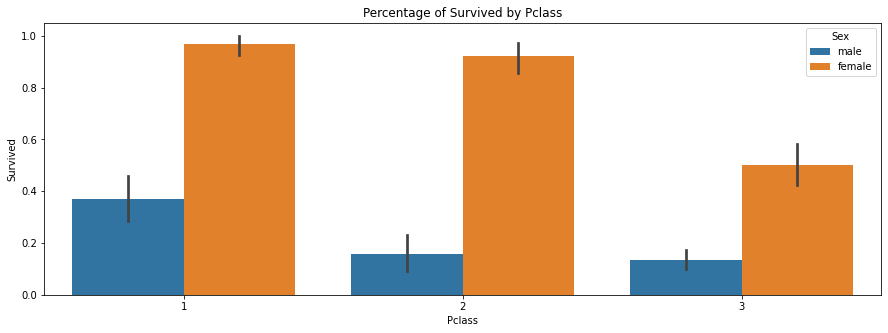

In [888]:
plot_data(data_df, 'Pclass', 'Survived', 'Sex') #It is better to be in 1 or 2 class

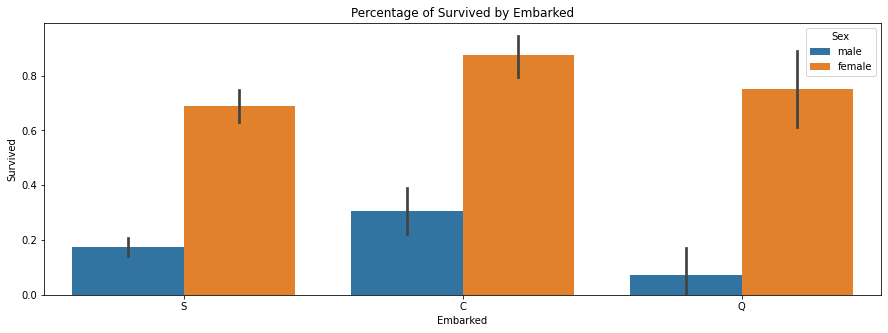

In [889]:
plot_data(data_df, 'Embarked', 'Survived', 'Sex')

In [890]:
groups = list(data_df[891:].loc[data_df[891:]['ChanceOfGroupSurvival'].isna(), 'PeopleGroup'].unique())

groups.remove('alone')
groups

['Klasen-3-S-12.1833-35040',
 'Peacock-3-S-13.775-SOTON/O.Q. 310131',
 'Billiard-3-S-14.5-A/5. 85',
 'Gibson-1-C-59.4-11237']

In [891]:
data_df.loc[data_df['PeopleGroup'].isin(groups), 'ChanceOfGroupSurvival'] = 0
data_df.loc[( data_df['PeopleGroup'].isin(groups)) & (data_df['Pclass'] == 1), 'ChanceOfGroupSurvival'] = 1

In [892]:
#Further preprocessing
data_df[891:]['ChanceOfGroupSurvival'].isna().sum() 


344

In [893]:
#We can estimate change of survival for males with grouping by classes
data_df['ChanceOfGroupSurvival'] = data_df['ChanceOfGroupSurvival'].fillna(data_df.groupby(['Pclass'])['ChanceOfGroupSurvival'].transform('mean'))
data_df[891:]['ChanceOfGroupSurvival'].isna().sum() 


0

In [894]:
mask = (data_df['Title'] == 'man')
# I've scaled manually ChanceOfGroupSurvival for males
# because we know that their chances are lower
# scaling by 1/3 gave me best results so far 
data_df.loc[mask, 'ChanceOfGroupSurvival'] = data_df.loc[mask, 'ChanceOfGroupSurvival'] / 3.0

In [895]:
titles = list(data_df['Title(Copy)'].unique())

for title in titles:
    age_median = data_df.groupby('Title(Copy)')['Age'].median()[title]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title(Copy)'] == title), 'Age'] = age_median



data_df['Fare'].fillna(data_df['Fare'].median(), inplace=True)

# Making Bins because for some models it works better(I don't know why)
# It is good to set number of bins to the value that will catch people that are not adults
# It also gives better results when there is at least one bin with upper boundary <= 18
data_df['FareInterval'] = pd.qcut(data_df['Fare'], 7)

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
data_df['FareInterval(Encoded)'] = label.fit_transform(data_df['FareInterval'])

data_df['AgeInterval'] = pd.qcut(data_df['Age'], 7)

label = LabelEncoder()
data_df['AgeInterval(Encoded)'] = label.fit_transform(data_df['AgeInterval'])

label = LabelEncoder()
data_df['Title(Encoded)'] = label.fit_transform(data_df['Title'])



In [896]:
X_train = data_df[:891]
X_test = data_df[891:]

In [897]:
X_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FamilyName,ExtendedTicket,PeopleGroup,GroupSize,ChanceOfGroupSurvival,FareInterval,FareInterval(Encoded),AgeInterval,AgeInterval(Encoded),Title(Encoded)
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,Braund,3-S-7.25-A/5 2117,alone,1.0,0.126225,"(-0.001, 7.75]",0,"(18.0, 22.0]",1,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,Cumings,1-C-71.2833-PC 1759,alone,1.0,0.939024,"(59.4, 512.329]",6,"(34.5, 43.143]",5,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,Heikkinen,3-S-7.925-STON/O2. 310128,alone,1.0,0.378676,"(7.75, 8.05]",1,"(22.0, 27.0]",2,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,Futrelle,1-S-53.1-11380,alone,1.0,0.939024,"(27.793, 59.4]",5,"(34.5, 43.143]",5,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,Allen,3-S-8.05-37345,alone,1.0,0.126225,"(7.75, 8.05]",1,"(34.5, 43.143]",5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0.0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,Montvila,2-S-13.0-21153,alone,1.0,0.333333,"(12.875, 19.258]",3,"(22.0, 27.0]",2,1
887,888,1.0,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,Graham,1-S-30.0-11205,alone,1.0,0.939024,"(27.793, 59.4]",5,"(18.0, 22.0]",1,2
888,889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.0,1,2,W./C. 6607,23.4500,...,Johnston,3-S-23.45-W./C. 660,Johnston-3-S-23.45-W./C. 660,3.0,0.000000,"(19.258, 27.793]",4,"(18.0, 22.0]",1,2
889,890,1.0,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,Behr,1-C-30.0-11136,alone,1.0,0.313008,"(27.793, 59.4]",5,"(22.0, 27.0]",2,1


In [898]:
X_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Title(Copy)',
       'FamilyName', 'ExtendedTicket', 'PeopleGroup', 'GroupSize',
       'ChanceOfGroupSurvival', 'FareInterval', 'FareInterval(Encoded)',
       'AgeInterval', 'AgeInterval(Encoded)', 'Title(Encoded)'],
      dtype='object')

In [899]:
cols_to_drop = ['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Title(Copy)', 'FamilyName', 'ExtendedTicket', 'PeopleGroup', 'FareInterval', 'AgeInterval']

y_train = X_train['Survived'].copy()
X_train.drop(cols_to_drop, axis=1, inplace=True)
X_train

X_test.drop(cols_to_drop, axis=1, inplace=True)

/var/folders/rl/pyfz32cs4rq01p8c57cwqj6m0000gn/T/ipykernel_32566/3341967100.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(cols_to_drop, axis=1, inplace=True)
/var/folders/rl/pyfz32cs4rq01p8c57cwqj6m0000gn/T/ipykernel_32566/3341967100.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(cols_to_drop, axis=1, inplace=True)


In [901]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [905]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

param_grid = {
    'n_neighbors': [n for n in range(5, 20)],
    'leaf_size': [n for n in range(1, 35)]
}
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, verbose=10)

grid.fit(X_train, y_train)


Fitting 20 folds for each of 684 candidates, totalling 13680 fits
[CV 1/20; 1/684] START leaf_size=2, n_neighbors=2...............................
[CV 1/20; 1/684] END leaf_size=2, n_neighbors=2;, score=0.889 total time=   0.0s
[CV 2/20; 1/684] START leaf_size=2, n_neighbors=2...............................
[CV 2/20; 1/684] END leaf_size=2, n_neighbors=2;, score=0.800 total time=   0.0s
[CV 3/20; 1/684] START leaf_size=2, n_neighbors=2...............................
[CV 3/20; 1/684] END leaf_size=2, n_neighbors=2;, score=0.756 total time=   0.0s
[CV 4/20; 1/684] START leaf_size=2, n_neighbors=2...............................
[CV 4/20; 1/684] END leaf_size=2, n_neighbors=2;, score=0.822 total time=   0.0s
[CV 5/20; 1/684] START leaf_size=2, n_neighbors=2...............................
[CV 5/20; 1/684] END leaf_size=2, n_neighbors=2;, score=0.822 total time=   0.0s
[CV 6/20; 1/684] START leaf_size=2, n_neighbors=2...............................
[CV 6/20; 1/684] END leaf_size=2, n_neighbo

GridSearchCV(cv=StratifiedKFold(n_splits=20, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                       24, 25, 26, 27, 28, 29, 30, 31, ...],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19]},
             verbose=10)

In [913]:
pred = grid.predict(X_test)

submission = pd.DataFrame({ 'PassengerId': data_df['PassengerId'][891:],
                            'Survived': pred.astype('int32') })
submission.to_csv("KNN_prediction.csv", index=False)
#Score: 0.80622

In [ ]:
#XGBOOST
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

from scipy.stats.distributions import uniform, randint

param_distribution = {
    'max_depth': randint(3, 40),
    'learning_rate': uniform(0.001, 0.999),
    'n_estimators': randint(400, 1000),
    'gamma': uniform(0,2),
    'colsample_bytree': uniform(0.5, 0.5),
    'subsample': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 15)
}

clf = RandomizedSearchCV(XGBClassifier(), param_distribution, random_state=0, n_iter=500)

clf.fit(X_train, y_train)

